# Toute la Data


Ridge


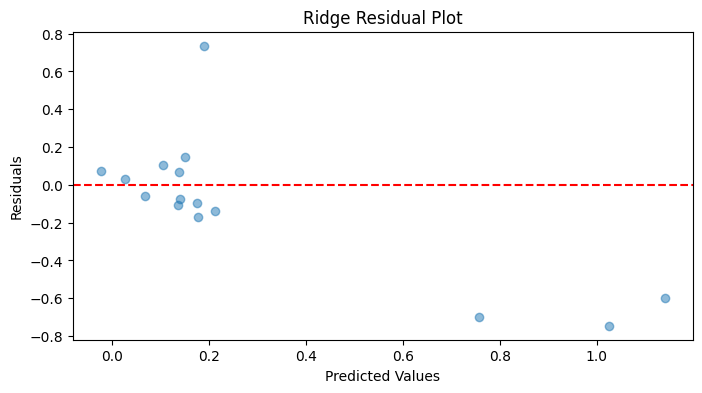

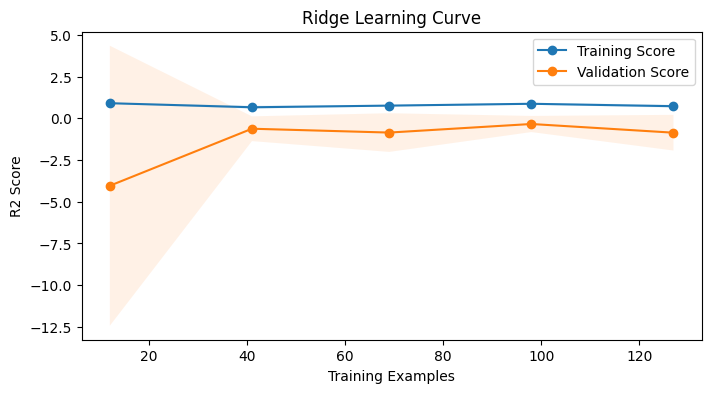


Lasso


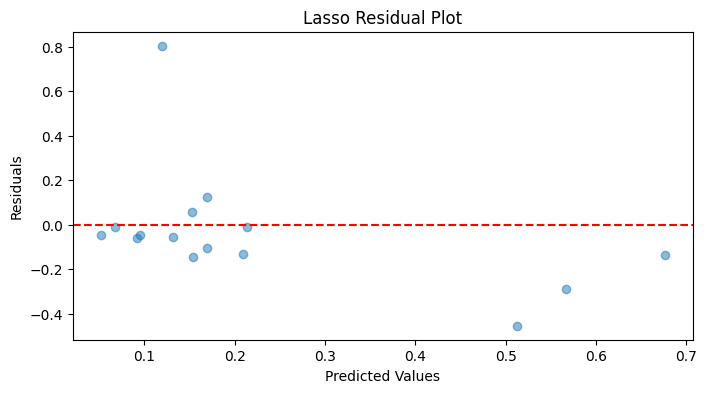

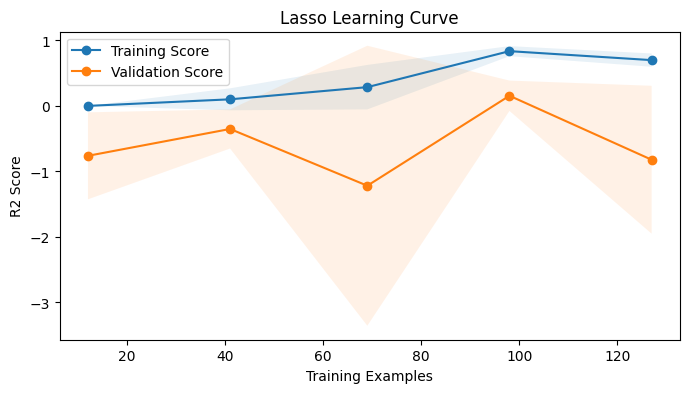


Decision Tree


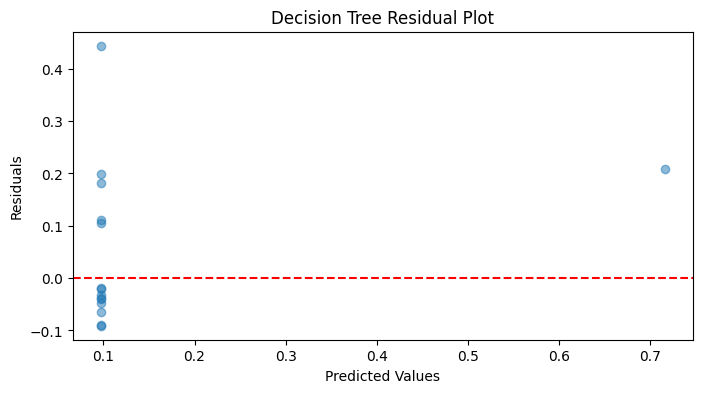

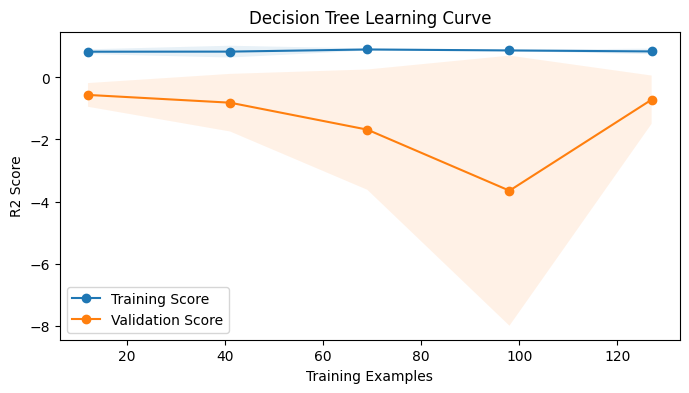


Random Forest


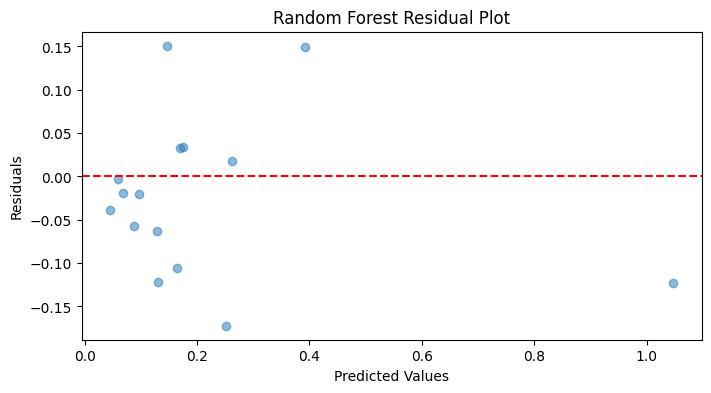

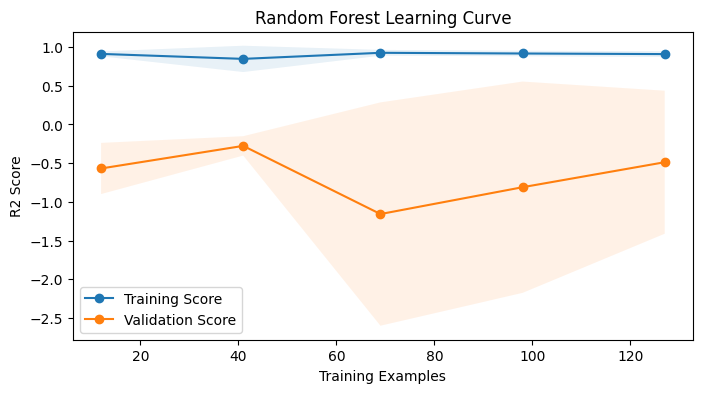


SVR


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


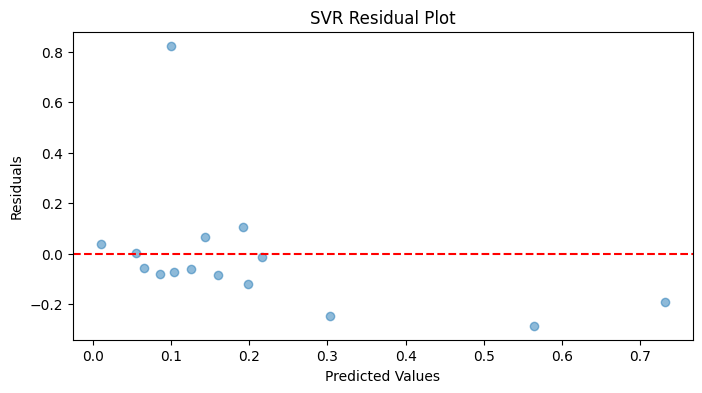

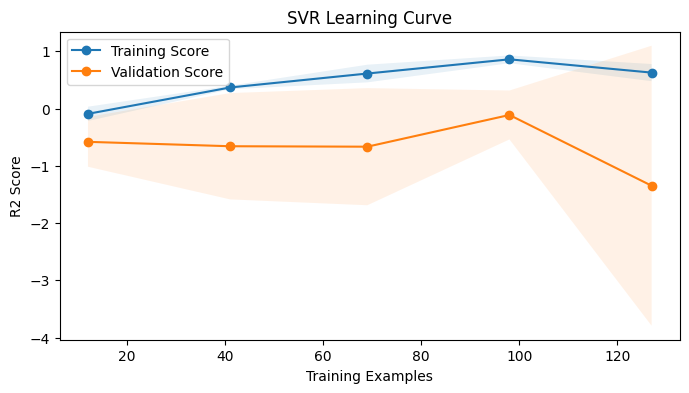


CatBoost


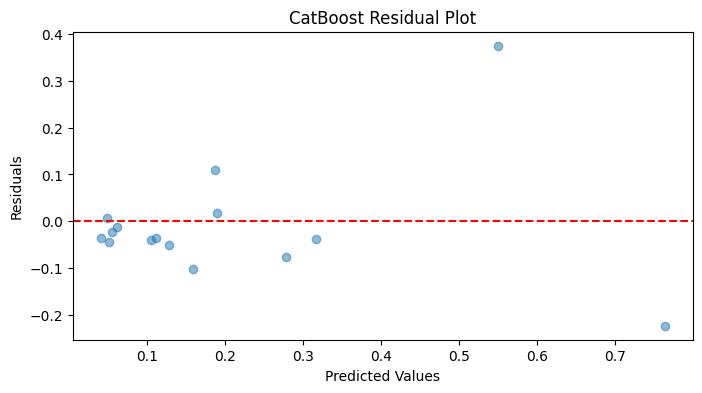

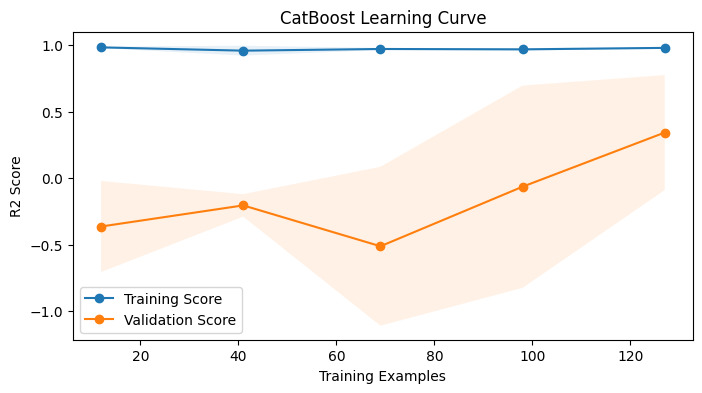



Final Results:
        Model         MAE        RMSE           R2    Train R2
        Ridge 0.21 ± 0.11 0.39 ± 0.22 -0.01 ± 0.81 0.68 ± 0.02
        Lasso 0.20 ± 0.12 0.37 ± 0.25  0.27 ± 0.47 0.66 ± 0.02
Decision Tree 0.17 ± 0.11 0.32 ± 0.27  0.57 ± 0.28 0.88 ± 0.07
Random Forest 0.14 ± 0.09 0.26 ± 0.21  0.74 ± 0.19 0.91 ± 0.02
          SVR 0.18 ± 0.13 0.38 ± 0.32  0.44 ± 0.31 0.57 ± 0.04
     CatBoost 0.09 ± 0.07 0.16 ± 0.15  0.90 ± 0.07 0.97 ± 0.02


In [15]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --------------------------
# DATA IMPORT AND CLEANING (FIXED)
# --------------------------
# Load and prepare data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

# Proper NaN handling (CRITICAL FIX)
num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Define features and target
TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# --------------------------
# PREPROCESSING PIPELINES (FIXED SCALING)
# --------------------------
# For non-CatBoost models (scales encoded categorical features)
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())  # Added categorical feature scaling
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

# For CatBoost (no encoding needed)
catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'  # Preserve raw categorical features
)

# --------------------------
# MODEL CONFIGURATIONS 
# --------------------------
models = {
    'Ridge': (Ridge(), {'model__alpha': [0.1, 0.5, 1, 2]}),
    'Lasso': (Lasso(), {'model__alpha': [0.1, 0.5, 1]}),
    'Decision Tree': (DecisionTreeRegressor(), {
        'model__max_depth': [3, 4, None],
        'model__min_samples_split': [5, 10],
        'model__min_samples_leaf': [2, 4]
    }),
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [30, 50],
        'model__max_depth': [3, 5],
        'model__min_samples_leaf': [2, 4]
    }),
    'SVR': (SVR(kernel='linear'), {
        'model__C': [3, 5.22, 7, 10],          # Focus around best value
        'model__epsilon': [0.08, 0.086, 0.09]
    
    }),
    'CatBoost': (CatBoostRegressor(verbose=0, 
        cat_features=list(range(len(num_cols), len(num_cols)+len(cat_cols)))),
        {'model__iterations': [50, 100],
         'model__depth': [3, 4],
         'model__learning_rate': [0.01, 0.1],
         'model__l2_leaf_reg': [1, 3]})
}

# --------------------------
# EVALUATION FRAMEWORK (WITH OVERFITTING CHECKS)
# --------------------------
results = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    print(f"\n{'='*30}\n{name}\n{'='*30}")
    
    # Create appropriate pipeline
    if name == 'CatBoost':
        pipeline = Pipeline([
            ('preprocessor', catboost_preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', general_preprocessor),
            ('model', model)
        ])
    
    # Hyperparameter search with model-specific iterations
    n_iter = 20 if name == 'SVR' else 3  # More thorough SVR tuning
    search = RandomizedSearchCV(pipeline, params, cv=5, n_iter=n_iter,
                               scoring='neg_mean_absolute_error', n_jobs=-1)
    search.fit(X, y)
    
    # Cross-validation metrics
    mae_scores, rmse_scores, r2_scores = [], [], []
    train_r2_scores = []  # Track training performance
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        search.best_estimator_.fit(X_train, y_train)
        y_pred = search.best_estimator_.predict(X_test)
        
        # Training metrics (overfitting check)
        train_pred = search.best_estimator_.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_r2_scores.append(train_r2)
        
        # Test metrics
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
    
    # Store results with training metrics
    results.append({
        'Model': name,
        'MAE': f"{np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}",
        'RMSE': f"{np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}",
        'R2': f"{np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}",
        'Train R2': f"{np.mean(train_r2_scores):.2f} ± {np.std(train_r2_scores):.2f}"
    })
    
    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        search.best_estimator_, X, y, cv=5, 
        scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    
    plt.figure(figsize=(8,4))
    plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, 1), 'o-', label='Validation Score')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, 1) - np.std(train_scores, 1),
                     np.mean(train_scores, 1) + np.std(train_scores, 1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(test_scores, 1) - np.std(test_scores, 1),
                     np.mean(test_scores, 1) + np.std(test_scores, 1), 
                     alpha=0.1)
    plt.title(f'{name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()



# --------------------------
# RESULTS DISPLAY (WITH TRAINING METRICS)
# --------------------------
results_df = pd.DataFrame(results)
print("\n\nFinal Results:")
print(results_df.to_string(index=False))


# LOG on target correctly


Ridge


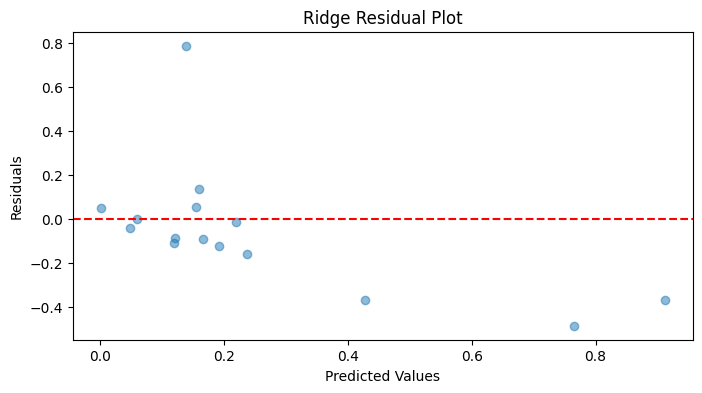

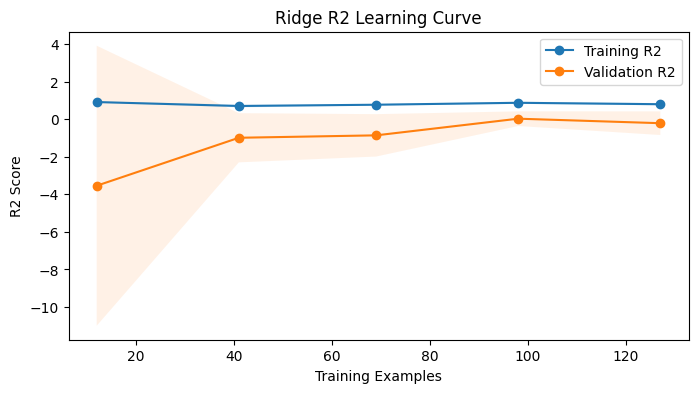

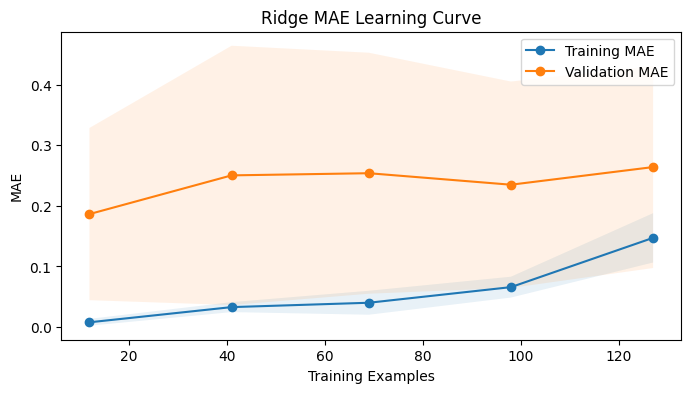


Lasso


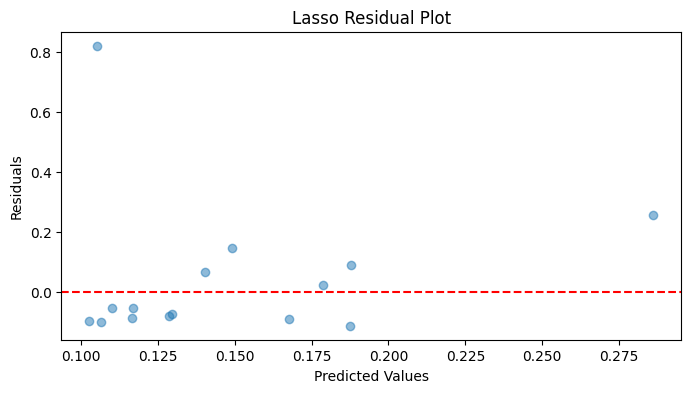

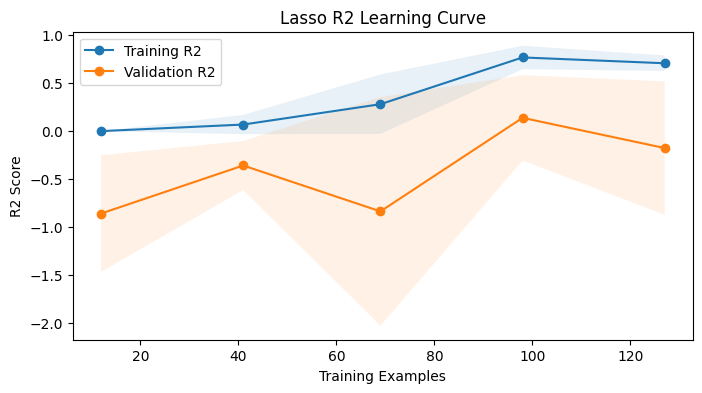

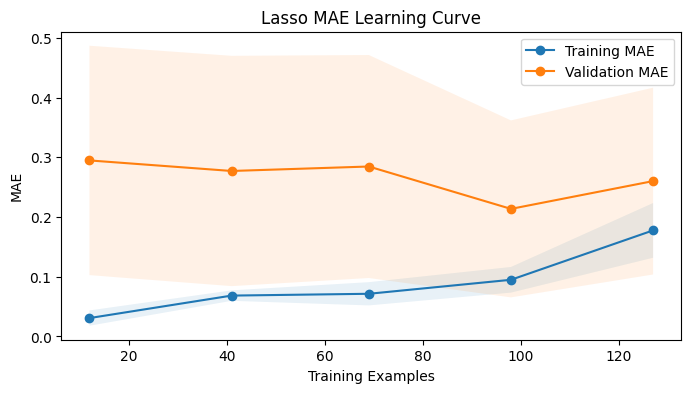


Decision Tree


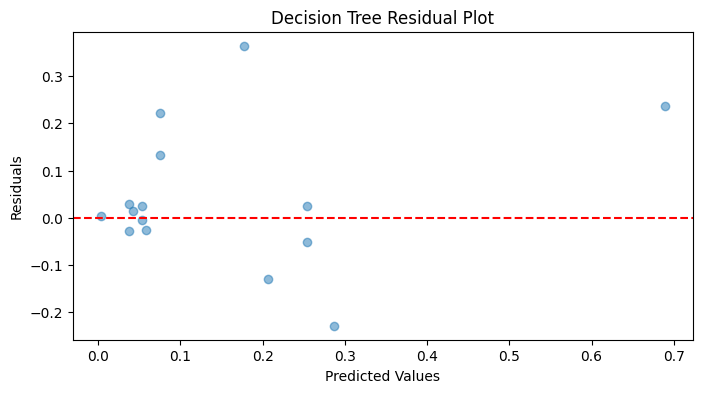

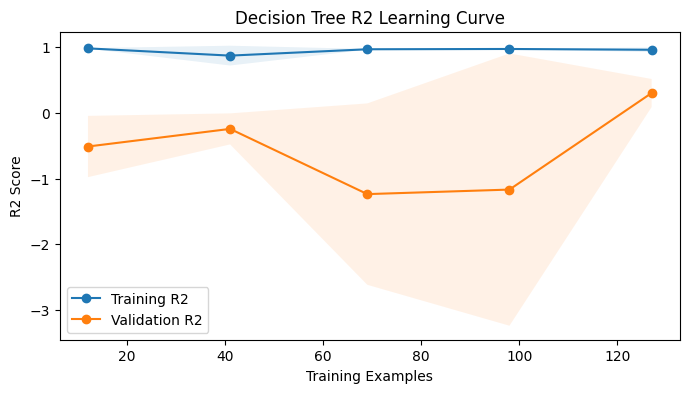

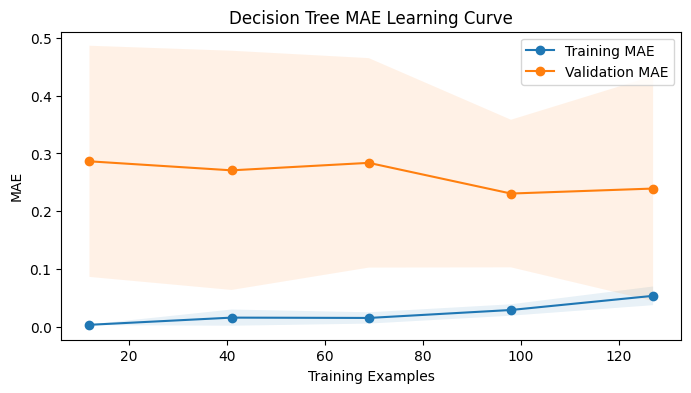


Random Forest


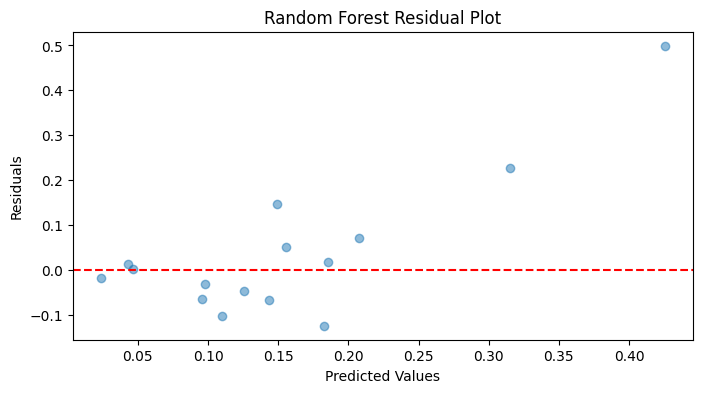

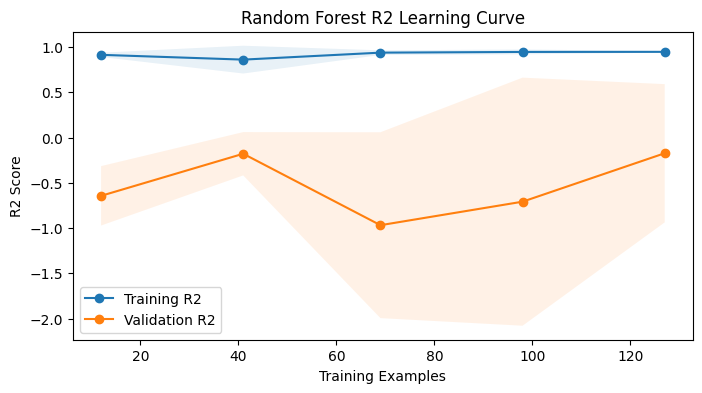

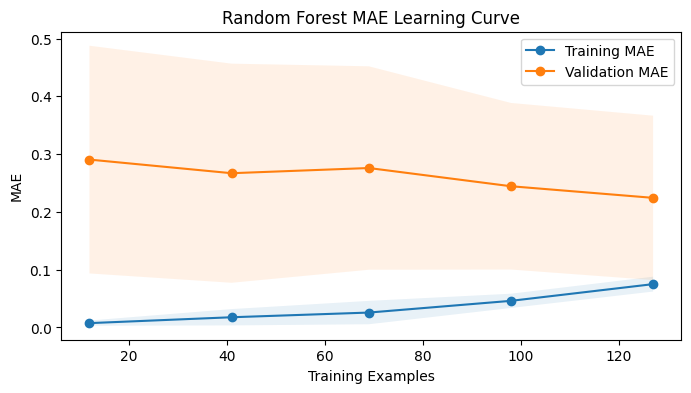


SVR


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


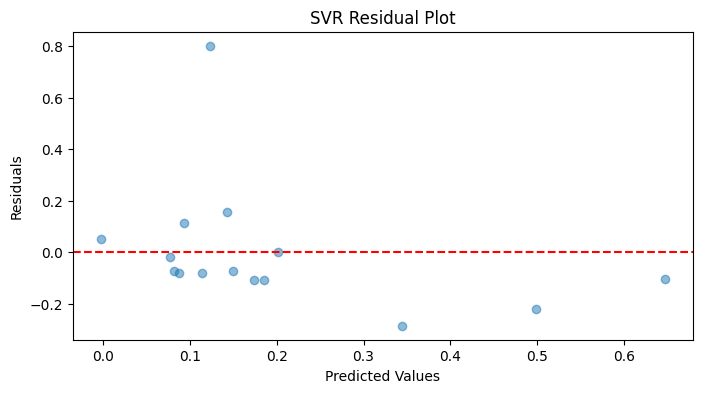

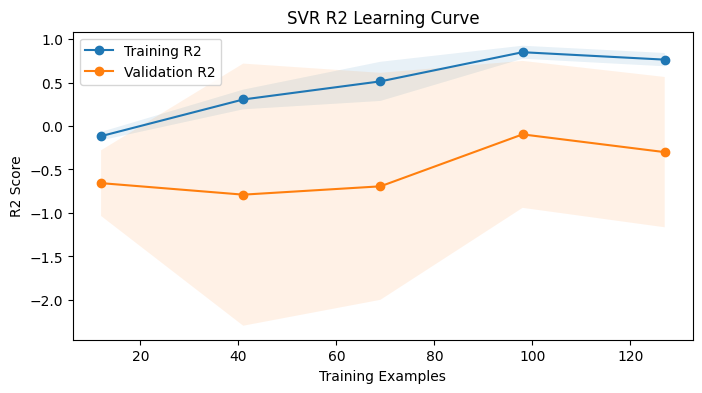

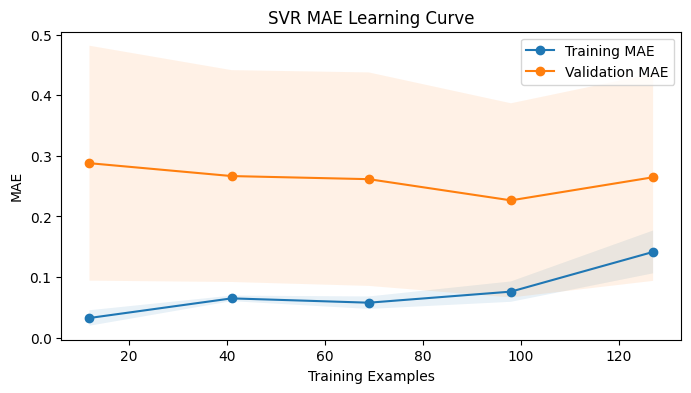


CatBoost


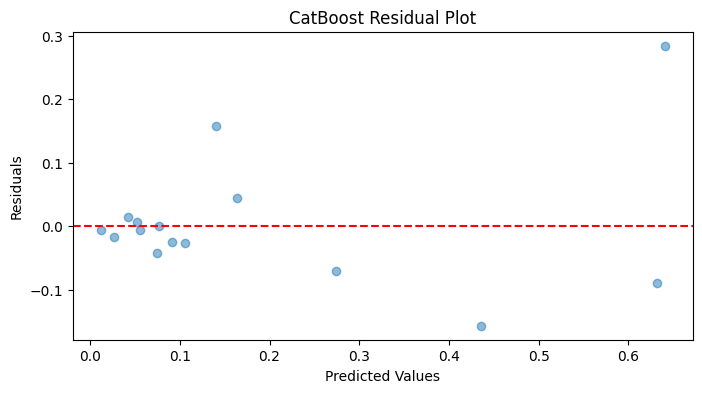

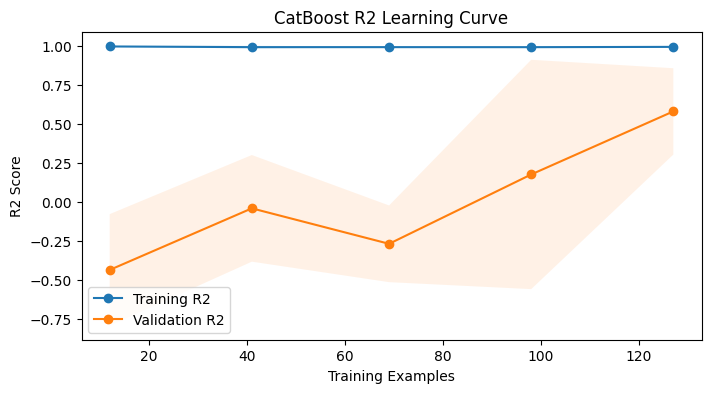

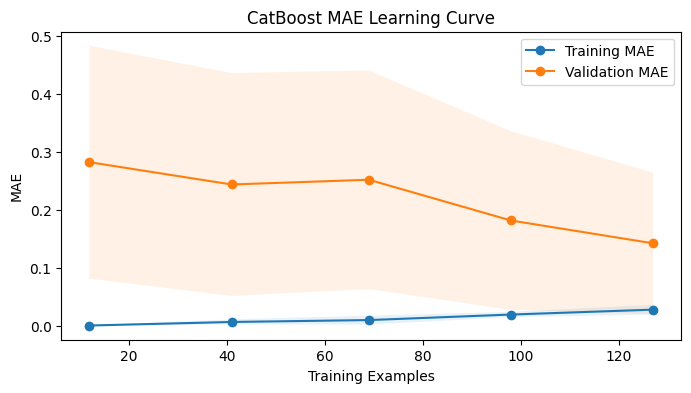



Final Results:
        Model         MAE        RMSE          R2    Train R2
        Ridge 0.18 ± 0.11 0.36 ± 0.26 0.38 ± 0.39 0.68 ± 0.02
        Lasso 0.21 ± 0.13 0.38 ± 0.29 0.36 ± 0.32 0.58 ± 0.02
Decision Tree 0.16 ± 0.10 0.35 ± 0.27 0.03 ± 2.00 0.91 ± 0.05
Random Forest 0.14 ± 0.10 0.26 ± 0.23 0.74 ± 0.18 0.88 ± 0.05
          SVR 0.18 ± 0.12 0.36 ± 0.32 0.48 ± 0.29 0.60 ± 0.04
     CatBoost 0.08 ± 0.06 0.17 ± 0.14 0.90 ± 0.05 0.99 ± 0.01


In [18]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA IMPORT AND CLEANING (WITH LOG TRANSFORM)
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)  # Log-transform the target

# --------------------------
# PREPROCESSING PIPELINES
# --------------------------
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

# --------------------------
# MODEL CONFIGURATIONS 
# --------------------------
models = {
    'Ridge': (Ridge(), {'model__alpha': [0.1, 0.5, 1, 2]}),
    'Lasso': (Lasso(), {'model__alpha': [0.1, 0.5, 1]}),
    'Decision Tree': (DecisionTreeRegressor(), {
        'model__max_depth': [3, 4, None],
        'model__min_samples_split': [5, 10],
        'model__min_samples_leaf': [2, 4]
    }),
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [30, 50],
        'model__max_depth': [3, 5],
        'model__min_samples_leaf': [2, 4]
    }),
    'SVR': (SVR(kernel='linear'), {
        'model__C': [3, 5.22, 7, 10],
        'model__epsilon': [0.08, 0.086, 0.09]
    }),
    'CatBoost': (CatBoostRegressor(verbose=0, 
        cat_features=list(range(len(num_cols), len(num_cols)+len(cat_cols)))),
        {'model__iterations': [50, 100],
         'model__depth': [3, 4],
         'model__learning_rate': [0.01, 0.1],
         'model__l2_leaf_reg': [1, 3]})
}

# --------------------------
# CUSTOM MAE SCORER FOR ORIGINAL SCALE
# --------------------------
def mae_exp_scorer(estimator, X, y_log):
    y_pred_log = estimator.predict(X)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_log)
    return -mean_absolute_error(y_true, y_pred)  # Negative for sklearn convention

# --------------------------
# EVALUATION FRAMEWORK
# --------------------------
results = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    print(f"\n{'='*30}\n{name}\n{'='*30}")
    
    if name == 'CatBoost':
        pipeline = Pipeline([
            ('preprocessor', catboost_preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', general_preprocessor),
            ('model', model)
        ])
    
    n_iter = 20 if name == 'SVR' else 3
    search = RandomizedSearchCV(
        pipeline, params, cv=5, n_iter=n_iter,
        scoring='neg_mean_absolute_error', n_jobs=-1)
    search.fit(X, y)
    
    mae_scores, rmse_scores, r2_scores = [], [], []
    train_r2_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test_original = y_original.iloc[test_idx]
        
        search.best_estimator_.fit(X_train, y_train)
        log_y_pred = search.best_estimator_.predict(X_test)
        y_pred = np.expm1(log_y_pred)
        
        log_train_pred = search.best_estimator_.predict(X_train)
        train_pred = np.expm1(log_train_pred)
        train_r2 = r2_score(y_original.iloc[train_idx], train_pred)
        train_r2_scores.append(train_r2)
        
        mae_scores.append(mean_absolute_error(y_test_original, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test_original, y_pred)))
        r2_scores.append(r2_score(y_test_original, y_pred))
    
    results.append({
        'Model': name,
        'MAE': f"{np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}",
        'RMSE': f"{np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}",
        'R2': f"{np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}",
        'Train R2': f"{np.mean(train_r2_scores):.2f} ± {np.std(train_r2_scores):.2f}"
    })
    
    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred, y_test_original - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # R2 Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        search.best_estimator_, X, y, cv=5, 
        scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    plt.figure(figsize=(8,4))
    plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training R2')
    plt.plot(train_sizes, np.mean(test_scores, 1), 'o-', label='Validation R2')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, 1) - np.std(train_scores, 1),
                     np.mean(train_scores, 1) + np.std(train_scores, 1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(test_scores, 1) - np.std(test_scores, 1),
                     np.mean(test_scores, 1) + np.std(test_scores, 1), 
                     alpha=0.1)
    plt.title(f'{name} R2 Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()
    
    # MAE Learning curve (on original scale)
    train_sizes_mae, train_scores_mae, test_scores_mae = learning_curve(
        search.best_estimator_, X, y, cv=5,
        scoring=mae_exp_scorer, train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    train_scores_mae = -train_scores_mae
    test_scores_mae = -test_scores_mae
    plt.figure(figsize=(8,4))
    plt.plot(train_sizes_mae, np.mean(train_scores_mae, 1), 'o-', label='Training MAE')
    plt.plot(train_sizes_mae, np.mean(test_scores_mae, 1), 'o-', label='Validation MAE')
    plt.fill_between(train_sizes_mae, 
                    np.mean(train_scores_mae, 1) - np.std(train_scores_mae, 1),
                    np.mean(train_scores_mae, 1) + np.std(train_scores_mae, 1), 
                    alpha=0.1)
    plt.fill_between(train_sizes_mae, 
                    np.mean(test_scores_mae, 1) - np.std(test_scores_mae, 1),
                    np.mean(test_scores_mae, 1) + np.std(test_scores_mae, 1), 
                    alpha=0.1)
    plt.title(f'{name} MAE Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

# --------------------------
# RESULTS DISPLAY
# --------------------------
results_df = pd.DataFrame(results)
print("\n\nFinal Results:")
print(results_df.to_string(index=False))


# IQR


Ridge


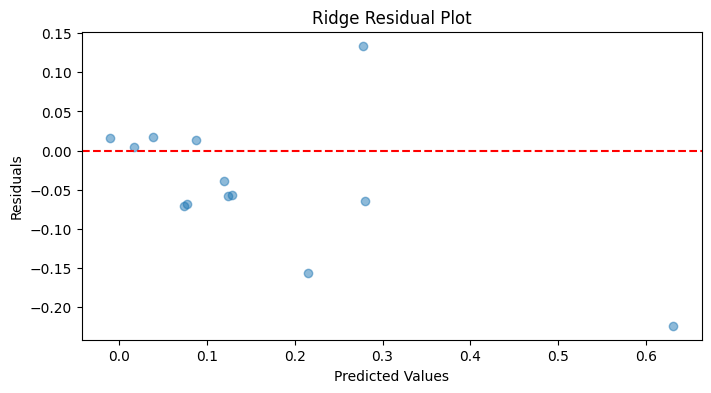

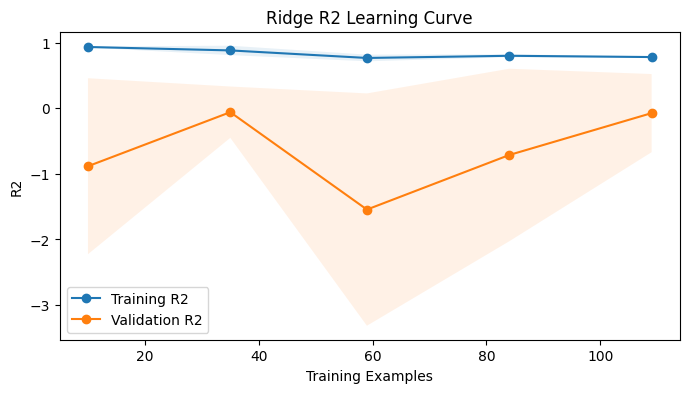

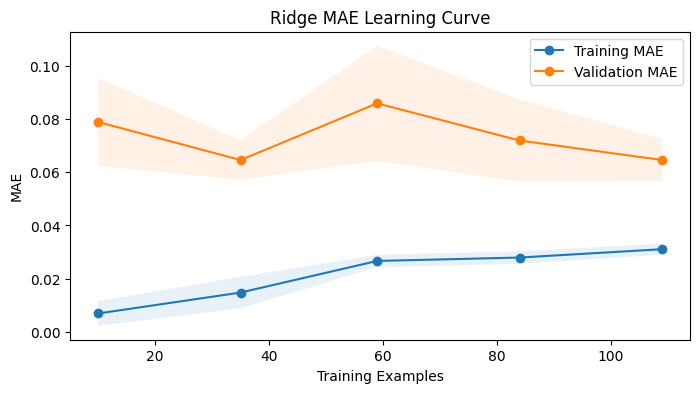


Lasso


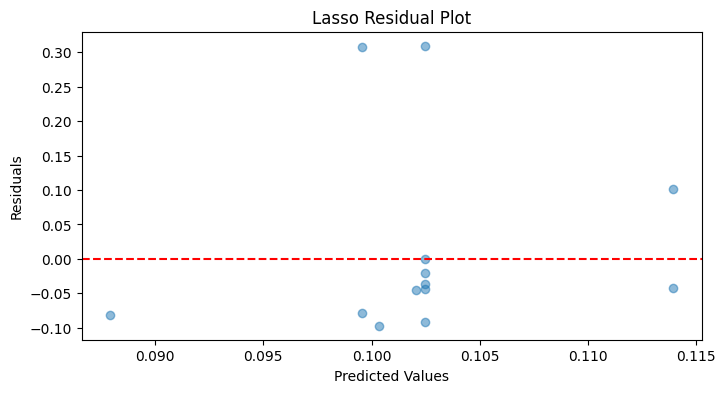

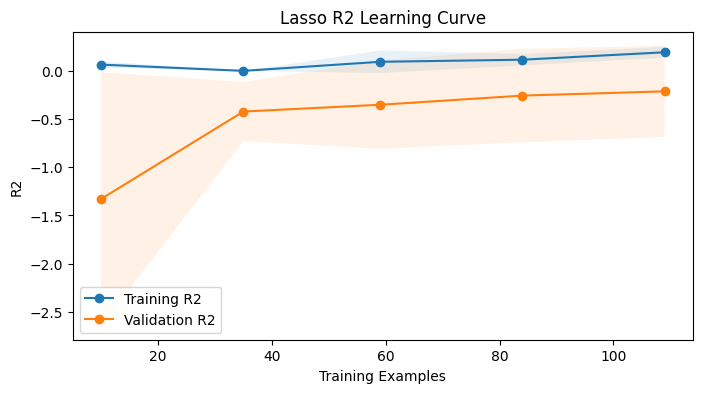

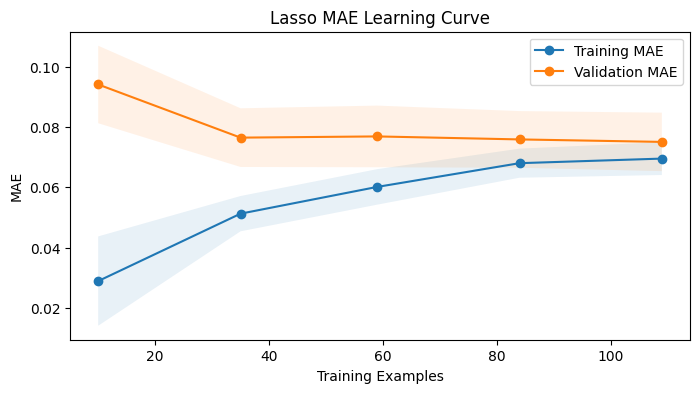


Decision Tree


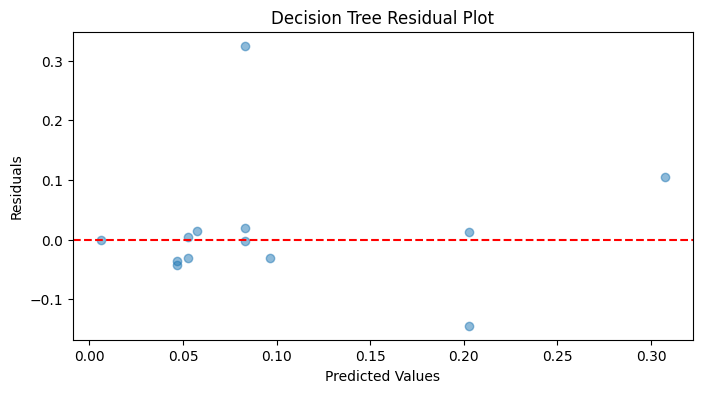

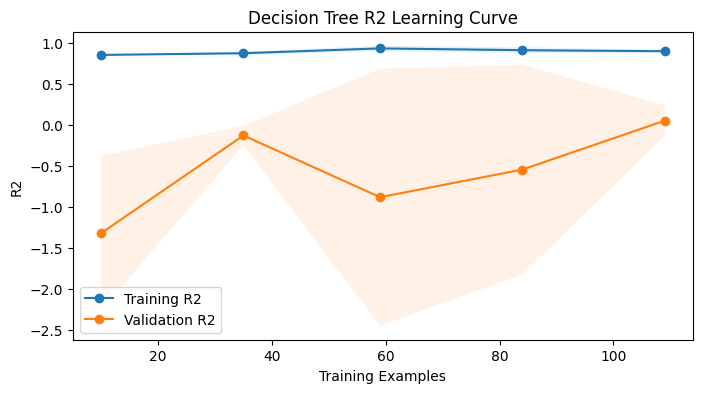

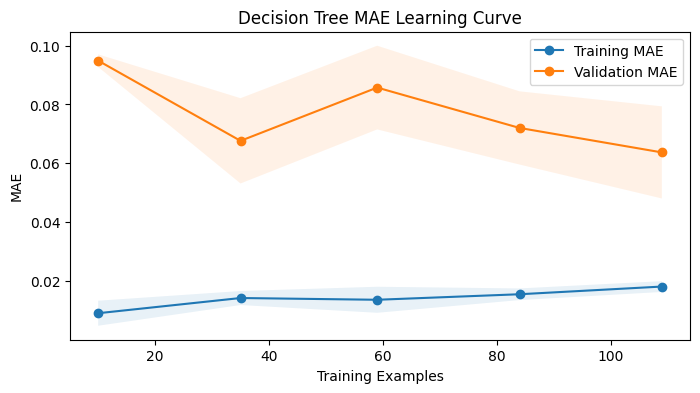


Random Forest


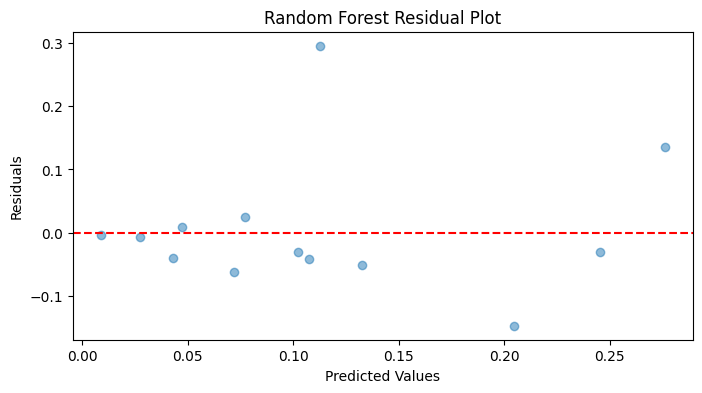

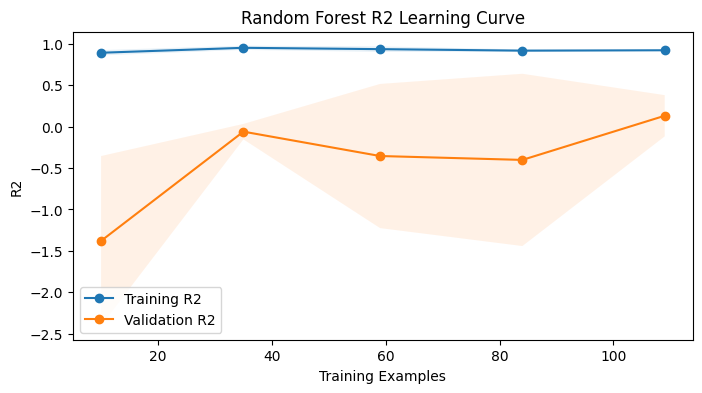

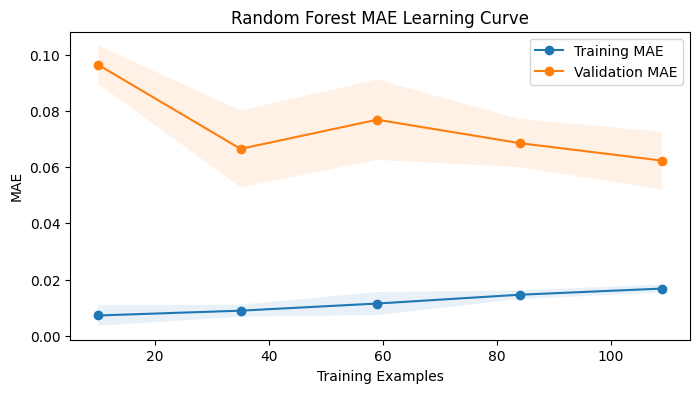


SVR


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


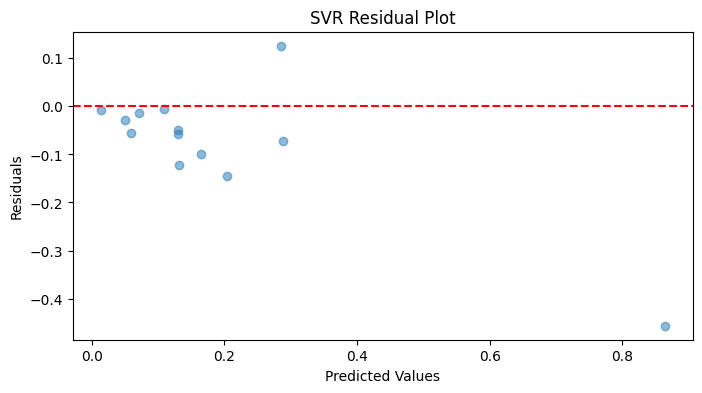

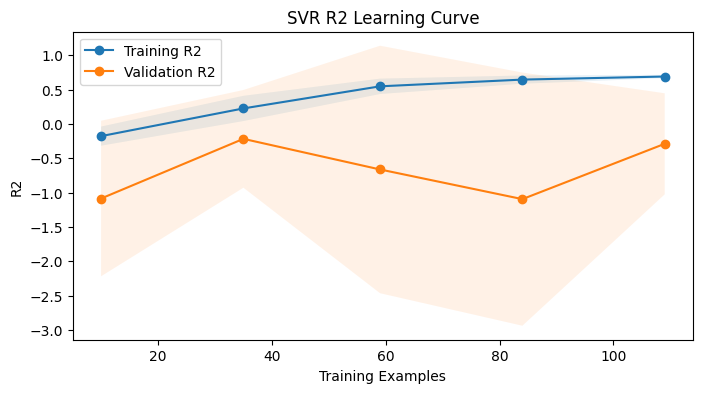

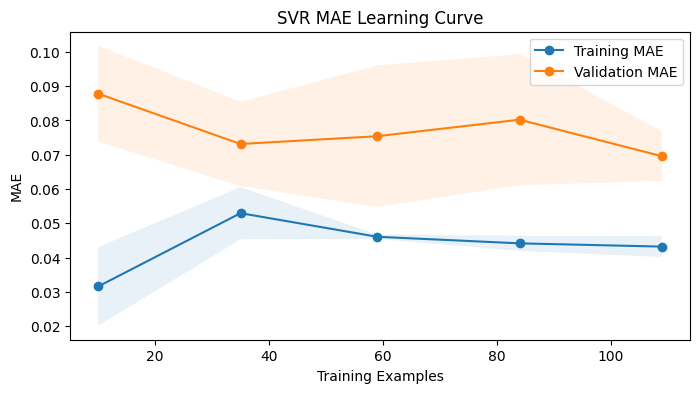


CatBoost


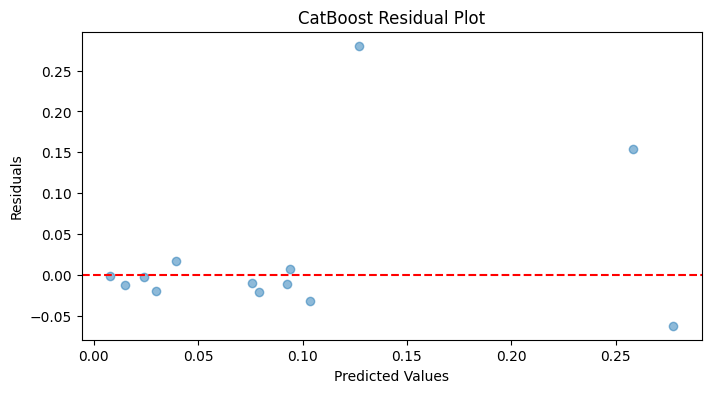

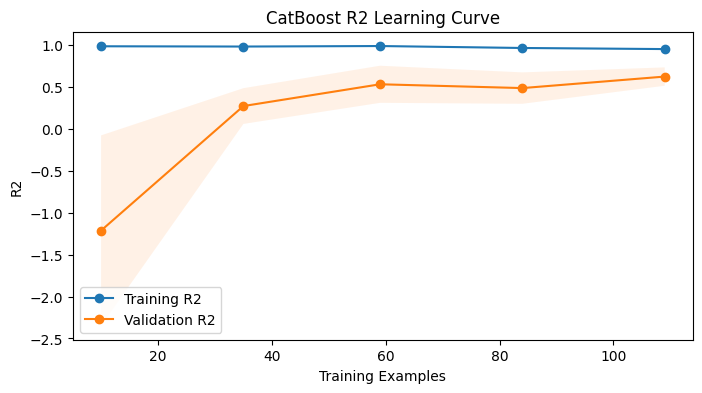

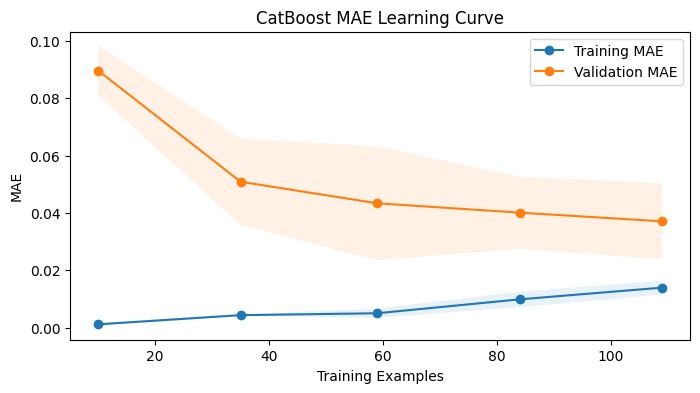



Final Results:
        Model         MAE        RMSE          R2    Train R2
        Ridge 0.05 ± 0.01 0.07 ± 0.02 0.43 ± 0.24 0.76 ± 0.02
        Lasso 0.07 ± 0.01 0.09 ± 0.02 0.02 ± 0.08 0.17 ± 0.05
Decision Tree 0.05 ± 0.01 0.08 ± 0.02 0.28 ± 0.33 0.90 ± 0.02
Random Forest 0.04 ± 0.01 0.07 ± 0.02 0.47 ± 0.20 0.92 ± 0.01
          SVR 0.06 ± 0.02 0.07 ± 0.03 0.34 ± 0.31 0.71 ± 0.01
     CatBoost 0.03 ± 0.01 0.05 ± 0.03 0.67 ± 0.24 0.95 ± 0.01


In [19]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA IMPORT, CLEANING & OUTLIER REMOVAL
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

# Handle missing values
num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# IQR-based outlier removal on target
TARGET = 'Total cost with amortization (€/part)'
Q1 = df[TARGET].quantile(0.25)
Q3 = df[TARGET].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
df = df[(df[TARGET] >= lower_bound) & (df[TARGET] <= upper_bound)]

# Define features and target
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# --------------------------
# PREPROCESSING PIPELINES (UNCHANGED)
# --------------------------
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

# --------------------------
# MODEL CONFIGURATIONS (UNCHANGED)
# --------------------------
models = {
    'Ridge': (Ridge(), {'model__alpha': [0.1, 0.5, 1, 2]}),
    'Lasso': (Lasso(), {'model__alpha': [0.1, 0.5, 1]}),
    'Decision Tree': (DecisionTreeRegressor(), {
        'model__max_depth': [3, 4, None],
        'model__min_samples_split': [5, 10],
        'model__min_samples_leaf': [2, 4]
    }),
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [30, 50],
        'model__max_depth': [3, 5],
        'model__min_samples_leaf': [2, 4]
    }),
    'SVR': (SVR(kernel='linear'), {
        'model__C': [3, 5.22, 7, 10],
        'model__epsilon': [0.08, 0.086, 0.09]
    }),
    'CatBoost': (CatBoostRegressor(verbose=0, 
        cat_features=list(range(len(num_cols), len(num_cols)+len(cat_cols)))),
        {'model__iterations': [50, 100],
         'model__depth': [3, 4],
         'model__learning_rate': [0.01, 0.1],
         'model__l2_leaf_reg': [1, 3]})
}

# --------------------------
# EVALUATION FRAMEWORK (SIMPLIFIED)
# --------------------------
results = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    print(f"\n{'='*30}\n{name}\n{'='*30}")
    
    if name == 'CatBoost':
        pipeline = Pipeline([
            ('preprocessor', catboost_preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', general_preprocessor),
            ('model', model)
        ])
    
    n_iter = 20 if name == 'SVR' else 3
    search = RandomizedSearchCV(
        pipeline, params, cv=5, n_iter=n_iter,
        scoring='neg_mean_absolute_error', n_jobs=-1)
    search.fit(X, y)
    
    mae_scores, rmse_scores, r2_scores = [], [], []
    train_r2_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        search.best_estimator_.fit(X_train, y_train)
        y_pred = search.best_estimator_.predict(X_test)
        
        # Training metrics
        train_pred = search.best_estimator_.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_r2_scores.append(train_r2)
        
        # Test metrics
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
    
    results.append({
        'Model': name,
        'MAE': f"{np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}",
        'RMSE': f"{np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}",
        'R2': f"{np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}",
        'Train R2': f"{np.mean(train_r2_scores):.2f} ± {np.std(train_r2_scores):.2f}"
    })
    
    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # Learning curves
    for scoring, title in [('r2', 'R2'), ('neg_mean_absolute_error', 'MAE')]:
        train_sizes, train_scores, test_scores = learning_curve(
            search.best_estimator_, X, y, cv=5,
            scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 5),
            n_jobs=-1
        )
        
        if scoring == 'neg_mean_absolute_error':
            train_scores = -train_scores
            test_scores = -test_scores
        
        plt.figure(figsize=(8,4))
        plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label=f'Training {title}')
        plt.plot(train_sizes, np.mean(test_scores, 1), 'o-', label=f'Validation {title}')
        plt.fill_between(train_sizes, 
                        np.mean(train_scores, 1) - np.std(train_scores, 1),
                        np.mean(train_scores, 1) + np.std(train_scores, 1), 
                        alpha=0.1)
        plt.fill_between(train_sizes, 
                        np.mean(test_scores, 1) - np.std(test_scores, 1),
                        np.mean(test_scores, 1) + np.std(test_scores, 1), 
                        alpha=0.1)
        plt.title(f'{name} {title} Learning Curve')
        plt.xlabel('Training Examples')
        plt.ylabel(title)
        plt.legend()
        plt.show()

# --------------------------
# RESULTS DISPLAY
# --------------------------
results_df = pd.DataFrame(results)
print("\n\nFinal Results:")
print(results_df.to_string(index=False))
